In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [ ]:
data = pd.read_csv('/content/drive/My Drive/PID in LHC/training.csv.gz')
data.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,TrackQualitySubdetector2,FlagPrs,DLLelectron,DLLkaon,EcalE,TrackQualityPerNDoF,DLLproton,PrsDLLbeElectron,FlagRICH1,MuonLLbeBCK,FlagHcal,EcalShowerLongitudinalParameter,Calo2dFitQuality,TrackPt,TrackDistanceToZ,RICHpFlagPion,HcalDLLbeElectron,Calo3dFitQuality,FlagEcal,MuonLLbeMuon,TrackNDoFSubdetector1,RICHpFlagProton,RICHpFlagKaon,GhostProbability,TrackQualitySubdetector1,Label,RICH_DLLbeBCK,FlagRICH2,FlagBrem,HcalDLLbeMuon,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
0,74791.156263,15.0,0.232275,1.0,1.0,3.2,-2.505719,6.604153,1.0,1.929960,17.585680,1.0,-6.411697,-7.213295,0.000001,1.467550,-26.667494,-2.730674,1.0,-5.152923,1.0,-999.000000,19.954819,3141.930677,0.613640,1.0,-0.909544,-999.000000,1.0,-0.661823,4.0,1.0,1.0,0.018913,5.366212,Muon,-21.913000,1.0,1.0,1.015345,28.0,1.0,-7.213300,-0.280200,5586.589846,1.0,1.0,10.422315,-2.081143e-07,-24.824400
1,2738.489989,15.0,-0.357748,0.0,1.0,3.2,1.864351,0.263651,1.0,-2.061959,20.230680,1.0,5.453014,0.000006,1531.542000,3.570540,-0.711194,1.773806,1.0,-999.000000,0.0,33.187644,0.037601,199.573653,0.465480,1.0,0.434909,13.667366,1.0,-999.000000,10.0,0.0,0.0,0.351206,9.144749,Ghost,-0.703617,0.0,1.0,-2.394644,32.0,1.0,-0.324317,1.707283,-0.000007,0.0,1.0,43.334935,2.771583e+00,-0.648017
2,2161.409908,17.0,-999.000000,0.0,0.0,-999.0,-999.000000,-999.000000,0.0,-999.000000,11.619878,0.0,-999.000000,-999.000000,-999.000000,0.826442,-999.000000,-999.000000,0.0,-999.000000,0.0,-999.000000,-999.000000,94.829418,0.241891,0.0,-999.000000,-999.000000,0.0,-999.000000,5.0,0.0,0.0,0.195717,1.459992,Ghost,-999.000000,0.0,0.0,-999.000000,27.0,0.0,-999.000000,-999.000000,-999.000000,0.0,0.0,-999.000000,-9.990000e+02,-999.000000
3,15277.730490,20.0,-0.638984,0.0,1.0,3.2,-2.533918,-8.724949,1.0,-3.253981,15.336305,1.0,-10.616585,-39.447507,4385.688000,1.076721,-29.291509,-3.053104,1.0,-999.000000,1.0,231.190351,2.839508,808.631064,0.680705,1.0,-1.504160,1939.259641,1.0,-999.000000,9.0,0.0,1.0,0.003972,22.950573,Pion,-47.223118,1.0,1.0,-0.321242,36.0,1.0,-35.202221,-14.742319,4482.803707,0.0,1.0,2.194175,-3.070819e+00,-29.291519
4,7563.700195,19.0,-0.638962,0.0,1.0,3.2,-2.087146,-7.060422,1.0,-0.995816,10.954629,1.0,-8.144945,26.050386,1220.930044,0.439767,21.386587,-2.730648,1.0,-999.000000,1.0,-794.866475,1.209193,1422.569214,0.575066,1.0,-1.576249,1867.165142,1.0,-999.000000,5.0,0.0,0.0,0.015232,3.516173,Proton,15.304688,0.0,1.0,-1.038026,33.0,1.0,25.084287,-10.272412,5107.554680,0.0,1.0,0.000015,-5.373712e+00,23.653087


In [ ]:
label_class_correspondence = {'Electron' : 0, 'Ghost' : 1, 'Kaon' : 2, 'Muon' : 3, 'Pion' : 4, 'Proton' : 5}
class_label_correspondence = {0 : 'Electron', 1 : 'Ghost', 2 : 'Kaon', 3 : 'Muon', 4 : 'Pion', 5 : 'Proton'}

def get_class_id(labels):
  return np.array([label_class_correspondence[alabel] for alabel in labels])

data['Class'] = get_class_id(data.Label.values)

In [ ]:
data['Class'] = get_class_id(data.Label.values)
set(data.Class)

{0, 1, 2, 3, 4, 5}

In [ ]:
set(data.Label)

{'Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton'}

In [ ]:
features = list(set(data.columns) - {'Label', 'Class'})
features

['TrackQualitySubdetector1',
 'FlagRICH2',
 'DLLkaon',
 'RICH_DLLbeKaon',
 'TrackNDoFSubdetector2',
 'GhostProbability',
 'FlagPrs',
 'RICHpFlagMuon',
 'TrackP',
 'EcalDLLbeMuon',
 'PrsE',
 'DLLelectron',
 'SpdE',
 'EcalDLLbeElectron',
 'EcalShowerLongitudinalParameter',
 'HcalDLLbeElectron',
 'Calo3dFitQuality',
 'RICHpFlagElectron',
 'TrackQualitySubdetector2',
 'EcalE',
 'MuonLooseFlag',
 'HcalDLLbeMuon',
 'FlagHcal',
 'RICHpFlagKaon',
 'RICH_DLLbeElectron',
 'RICH_DLLbeProton',
 'BremDLLbeElectron',
 'RICHpFlagPion',
 'MuonFlag',
 'MuonLLbeBCK',
 'FlagRICH1',
 'TrackNDoFSubdetector1',
 'TrackDistanceToZ',
 'MuonLLbeMuon',
 'RICHpFlagProton',
 'Calo2dFitQuality',
 'TrackPt',
 'FlagSpd',
 'PrsDLLbeElectron',
 'FlagEcal',
 'DLLmuon',
 'RICH_DLLbeBCK',
 'HcalE',
 'FlagMuon',
 'TrackQualityPerNDoF',
 'FlagBrem',
 'RICH_DLLbeMuon',
 'TrackNDoF',
 'DLLproton']

In [ ]:
training_data, validation_data = train_test_split(data, random_state=11, train_size=0.90)

In [ ]:
len(training_data), len(validation_data)

(1080000, 120000)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
training_data_scaled = scaler.fit_transform(training_data[features].values)
validation_data_scaled = scaler.fit_transform(validation_data[features].values)

In [ ]:
X_train_scaled = training_data_scaled.reshape(-1, 7, 7, 1)

In [ ]:
X_train_scaled.shape

(1080000, 7, 7, 1)

In [ ]:
import tensorflow as tf

steps_per_epoch = 1045
step = tf.Variable(0, trainable=False)
boundaries = []
for i in range(1, 4):
    boundaries.append(steps_per_epoch * (i * 100))
values = [1e-3, 1e-4, 1e-5, 1e-6]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

learning_rate = learning_rate_fn(step)

In [ ]:
def scheduler(epoch, lr):
    if epoch == 0:
        lr = 0.001
        return lr
    elif epoch == 100:
        lr = 0.0001
        return lr
    elif epoch == 200:
        lr = 0.00001
        return lr
    else:
        return lr

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        # If you want to apply decay.
        #lr = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print(tf.keras.backend.eval("\tLearning Rate: {}".format(float(lr))))
        #print("\t{}".format(step))

cb = MyCallback()

In [ ]:
lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
#lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False
optimizer = Adam()
model_cnn = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(64, 2, activation = 'tanh', input_shape = (49, 1)),
                                    tf.keras.layers.MaxPooling1D(),
                                    tf.keras.layers.Dropout(0.3),
                                    #tf.keras.layers.BatchNormalization(),
                                    #tf.keras.layers.Conv1D(32, 2, activation = 'tanh'),
                                    #tf.keras.layers.MaxPooling1D(),
                                    #tf.keras.layers.Dropout(0.5),
                                    #tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation = 'tanh'),
                                    tf.keras.layers.Dense(64, activation = 'tanh'),
                                    tf.keras.layers.Dense(6, activation = 'softmax')
])

model_cnn.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['acc'])
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 48, 64)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3

In [ ]:
hist = model_cnn.fit(X_train_scaled.reshape(-1, 49, 1), tf.keras.utils.to_categorical(training_data.Class.values), epochs = 500, validation_split=0.01, batch_size= 1024, callbacks=[cb, lr_cb])

Epoch 1/500
1045/1045 [==============================] - 10s 10ms/step - loss: 0.7679 - acc: 0.6947 - val_loss: 0.6451 - val_acc: 0.7406
Epoch 2/500
1045/1045 [==============================] - 10s 9ms/step - loss: 0.6576 - acc: 0.7328 - val_loss: 0.6090 - val_acc: 0.7511
Epoch 3/500
1045/1045 [==============================] - 10s 9ms/step - loss: 0.6347 - acc: 0.7402 - val_loss: 0.5983 - val_acc: 0.7542
Epoch 4/500
1045/1045 [==============================] - 10s 10ms/step - loss: 0.6240 - acc: 0.7437 - val_loss: 0.5884 - val_acc: 0.7560
Epoch 5/500
1045/1045 [==============================] - 10s 9ms/step - loss: 0.6173 - acc: 0.7461 - val_loss: 0.5931 - val_acc: 0.7519
Epoch 6/500
1045/1045 [==============================] - 10s 9ms/step - loss: 0.6115 - acc: 0.7482 - val_loss: 0.5818 - val_acc: 0.7588
Epoch 7/500
1045/1045 [==============================] - 10s 9ms/step - loss: 0.6079 - acc: 0.7492 - val_loss: 0.5790 - val_acc: 0.7564
Epoch 8/500
1045/1045 [=======================

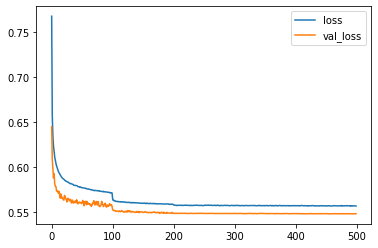

In [ ]:
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()


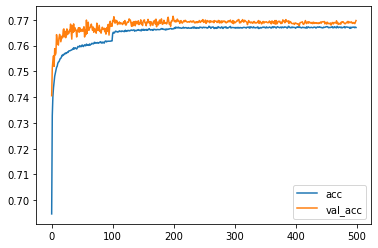

In [ ]:
plt.plot(hist.history['acc'], label = 'acc')
plt.plot(hist.history['val_acc'], label = 'val_acc')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy
import pandas
from sklearn.metrics import roc_curve, roc_auc_score


label_class_correspondence = {'Electron': 0, 'Ghost': 1, 'Kaon': 2, 'Muon': 3, 'Pion': 4, 'Proton': 5}
class_label_correspondence = {0: 'Electron', 1: 'Ghost', 2: 'Kaon', 3: 'Muon', 4: 'Pion', 5: 'Proton'}


def get_class_ids(labels):
    """
    Convert particle type names into class ids.
    Parameters:
    -----------
    labels : array_like
        Array of particle type names ['Electron', 'Muon', ...].
    Return:
    -------
    class ids : array_like
        Array of class ids [1, 0, 3, ...].
    """
    return numpy.array([label_class_correspondence[alabel] for alabel in labels])


def plot_roc_curves(predictions, labels):
    """
    Plot ROC curves.
    Parameters:
    -----------
    predictions : array_like
        Array of particle type predictions with shape=(n_particles, n_types).
    labels : array_like
        Array of class ids [1, 0, 3, ...].
    """
    plt.figure(figsize=(9, 6))
    u_labels = numpy.unique(labels)
    for lab in u_labels:
        y_true = labels == lab
        y_pred = predictions[:, lab]
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        plt.plot(tpr, 1-fpr, linewidth=3, label=class_label_correspondence[lab] + ', AUC = ' + str(numpy.round(auc, 4)))
        plt.xlabel('Signal efficiency (TPR)', size=15)
        plt.ylabel("Background rejection (1 - FPR)", size=15)
        plt.xticks(size=15)
        plt.yticks(size=15)
        plt.xlim(0., 1)
        plt.ylim(0., 1)
        plt.legend(loc='lower left', fontsize=15)
        plt.title('One particle vs rest ROC curves', loc='right', size=15)
        plt.grid(b=1)
        
        
def my_percentile(arr, w, q):

    left = 0.
    right = (w).sum()
    sort_inds = numpy.argsort(arr, axis=0)
    if left/right >= q/100.:
        return arr[0]
    for i in sort_inds:
        left += w[i]
        if left/right >= q/100.:
            return arr[i]

def base_plot(prediction, spectator, cut, percentile=True, weights=None, n_bins=100,
              color='b', marker='o', ms=4, label="MVA", fmt='o', markeredgecolor='b', markeredgewidth=2, ecolor='b'):
    """
    Base plot for signal efficiency.
    Parameters:
    -----------
    prediction : array_like
        Array of predictions for signal for a selected particle type with shape=(n_particles, ).
    spectator : array_like
        To plot dependence of signal efficiency on this feature.
    cut : float
        Global efficiency value.
    bins : int
        Number of bin for plot.
    """
    if weights is None:
        weights = numpy.ones(len(prediction))

    if percentile:
        if weights is None:
            cut = numpy.percentile(prediction, 100-cut)
        else:
            cut = my_percentile(prediction, weights, 100-cut)
    
    edges = numpy.linspace(spectator.min(), spectator.max(), n_bins)
    
    xx = []
    yy = []
    xx_err = []
    yy_err = []
    
    for i_edge in range(len(edges)-1):

        left = edges[i_edge]
        right = edges[i_edge + 1]
        
        N_tot_bin = weights[((spectator >= left) * (spectator < right))].sum()
        N_cut_bin = weights[((spectator >= left) * (spectator < right) * (prediction >= cut))].sum()
        
        if N_tot_bin != 0:
            
            x = 0.5 * (right + left)
            y = 1. * N_cut_bin / N_tot_bin
            
            if y > 1.:
                y = 1.
            if y < 0:
                y = 0
            
            xx.append(x)
            yy.append(y)
            
            x_err = 0.5 * (right - left)
            y_err = numpy.sqrt(y*(1-y)/N_tot_bin)
            
            xx_err.append(x_err)
            yy_err.append(y_err)
        
        else:
            pass

    plt.errorbar(xx, yy, yerr=yy_err, xerr=xx_err, fmt=fmt, color=color, marker=marker, ms=ms, label=label, markeredgecolor=markeredgecolor, markeredgewidth=markeredgewidth, ecolor=ecolor)
    
    return cut

def plot_signal_efficiency(predictions, labels, spectator, eff=60, n_bins=20, xlabel='Spectator'):
    """
    Plot dependence of signal efficiency from spectator feature for all particle types.
    Parameters:
    -----------
    prediction : array_like
        Array of predictions for signal for a selected particle type with shape=(n_particles, ).
    labels : array_like
        Array of class ids [1, 0, 3, ...].
    spectator : array_like
        To plot dependence of signal efficiency on this feature.
    cut : float
        Global efficiency value.
    bins : int
        Number of bin for plot.
    xlabel : string
        Label of x-axis.
    """
    
    plt.figure(figsize=(5.5*2, 3.5*3))
    u_labels = numpy.unique(labels)
    for lab in u_labels:
        y_true = labels == lab
        pred = predictions[y_true, lab]
        spec = spectator[y_true]
        plt.subplot(3, 2, lab+1)
        base_plot(pred, spec, cut=eff, percentile=True, weights=None, n_bins=n_bins, color='1', marker='o', 
                  ms=7, label=class_label_correspondence[lab], fmt='o')
        
        plt.plot([spec.min(), spec.max()], [eff / 100., eff / 100.], label='Global signal efficiency', color='r', linewidth=3)
        plt.legend(loc='best', fontsize=12)
        plt.xticks(size=12)
        plt.yticks(size=12)
        plt.ylabel('Signal efficiency (TPR)', size=12)
        plt.xlabel(xlabel,size=12)
        plt.ylim(0, 1)
        plt.xlim(spec.min(), spec.max())
        plt.grid(b=1)
    plt.tight_layout()
        

def plot_signal_efficiency_on_p(predictions, labels, spectator, eff=60, n_bins=20):
    """
    Plot dependence of signal efficiency from particle momentum feature for all particle types.
    Parameters:
    -----------
    prediction : array_like
        Array of predictions for signal for a selected particle type with shape=(n_particles, ).
    labels : array_like
        Array of class ids [1, 0, 3, ...].
    spectator : array_like
        To plot dependence of signal efficiency on this feature.
    cut : float
        Global efficiency value.
    bins : int
        Number of bin for plot.
    """
    sel = spectator < 200 * 10**3
    plot_signal_efficiency(predictions[sel], labels[sel], spectator[sel] / 10**3, eff, n_bins, 'Momentum, GeV/c')
    

def plot_signal_efficiency_on_pt(predictions, labels, spectator, eff=60, n_bins=20):
    """
    Plot dependence of signal efficiency from particle transverse momentum feature for all particle types.
    Parameters:
    -----------
    prediction : array_like
        Array of predictions for signal for a selected particle type with shape=(n_particles, ).
    labels : array_like
        Array of class ids [1, 0, 3, ...].
    spectator : array_like
        To plot dependence of signal efficiency on this feature.
    cut : float
        Global efficiency value.
    bins : int
        Number of bin for plot.
    """
    sel = spectator < 10 * 10**3
    plot_signal_efficiency(predictions[sel], labels[sel], spectator[sel] / 10**3, eff, n_bins, 'Transverse momentum, GeV/c')

In [ ]:
pred = model_cnn.predict(validation_data_scaled.reshape(-1, 49, 1))

In [ ]:
log_loss(validation_data.Class.values, pred)

0.5682079187040918

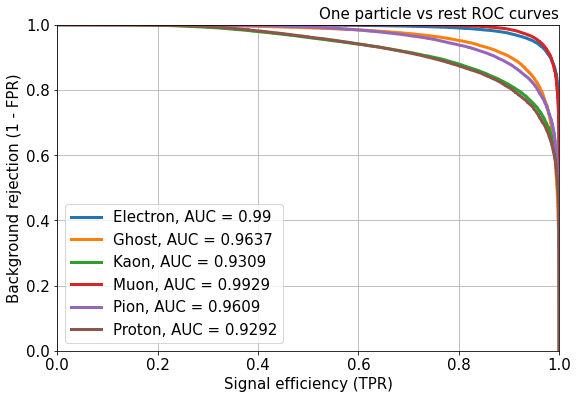

In [ ]:
plot_roc_curves(pred, validation_data.Class.values)

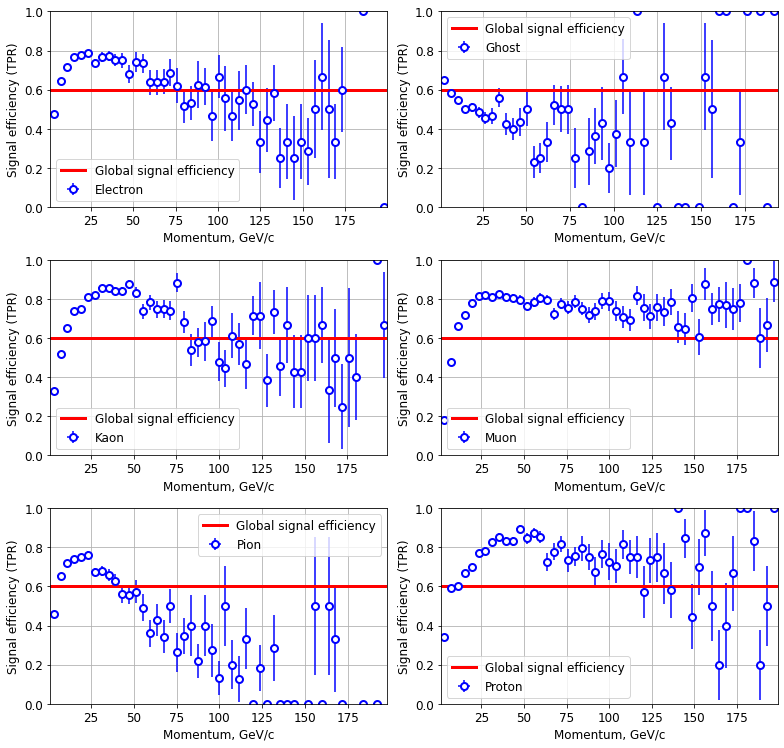

In [ ]:
plot_signal_efficiency_on_p(pred, validation_data.Class.values, validation_data.TrackP.values, 60, 50)
plt.show()


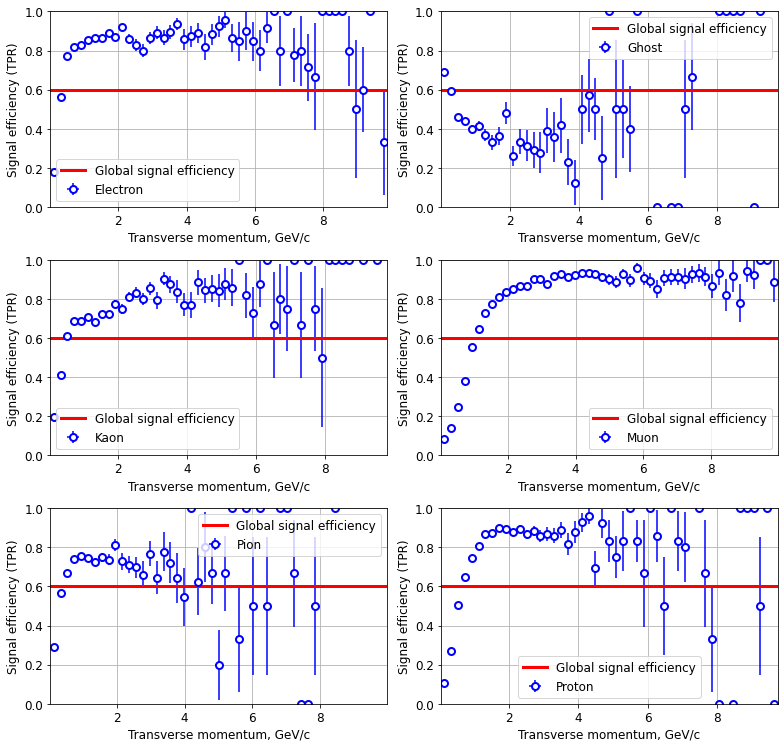

In [ ]:
plot_signal_efficiency_on_pt(pred, validation_data.Class.values, validation_data.TrackPt.values, 60, 50)
plt.show()

In [ ]:
model_cnn.save("/content/drive/My Drive/models/1D_CNN_model.h5")

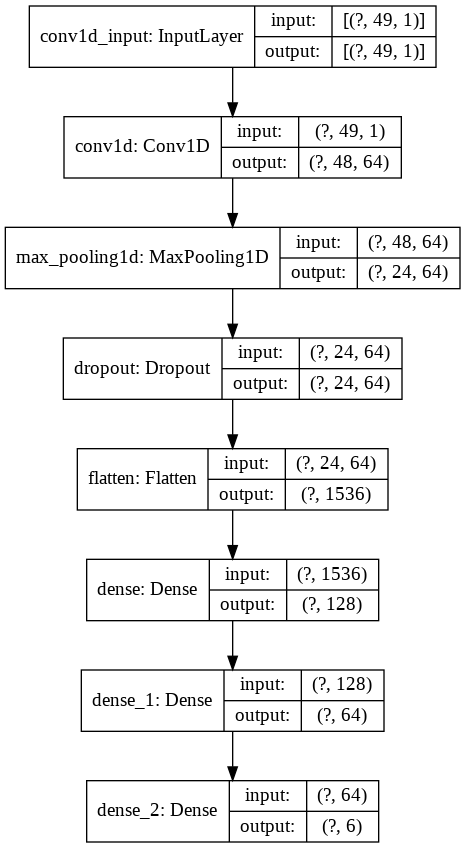

In [ ]:
tf.keras.utils.plot_model(model_cnn, to_file='/content/drive/My Drive/models/1D_CNN_model_plot.png', show_shapes=True, show_layer_names=True)